## Debugging the neural network: The effects of Dropout and BatchNormalization on the training curve

What I found: 

Dropout is the reason why the training curve fluctuates. <br>
BatchNormalization and Dropout decrease the amount of epochs to get to 0. <br>
The l1-l2 regularization increases the optimal loss from 0 to 6.

When we use either Dropout or BatchNormalization, we really need to train for ~100 epochs until convergence. Especially with our large batch size. A learning rate scheduler doesn't make any sense.

In [60]:
# Ran with 800GB (750GB should also be fine)

import sys
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import gc

#Import sklearn before tensorflow (static Thread-local storage)
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation

# For Leaky_ReLU:
from tensorflow import nn 

t0 = time.time()
path = '/pf/b/b309170'

qubicc_only = False
if qubicc_only:
    path_figures = path + '/workspace_icon-ml/cloud_cover_parameterization/grid_cell_based_QUBICC_R02B05/qubicc_only/figures'
    path_model = path + '/workspace_icon-ml/cloud_cover_parameterization/grid_cell_based_QUBICC_R02B05/qubicc_only/saved_models'
else:
    path_figures = path + '/workspace_icon-ml/cloud_cover_parameterization/grid_cell_based_QUBICC_R02B05/figures'
    path_model = path + '/workspace_icon-ml/cloud_cover_parameterization/grid_cell_based_QUBICC_R02B05/saved_models'

path_data = path + '/my_work/icon-ml_data/cloud_cover_parameterization/grid_cell_based_QUBICC_R02B05/based_on_var_interpolated_data'

# Add path with my_classes to sys.path
sys.path.insert(0, path + '/workspace_icon-ml/cloud_cover_parameterization/')

# Reloading custom file to incorporate changes dynamically
import importlib
import my_classes
importlib.reload(my_classes)

from my_classes import read_mean_and_std
from my_classes import TimeOut

# Minutes per fold
timeout = 2120 

# For logging purposes
days = 'all_days'

# Maximum amount of epochs for each model
# epochs = 30 ##
epochs = 8 ## Just for this qubicc_only run

# Set seed for reproducibility
seed = 10
tf.random.set_seed(seed)

# For store_mean_model_biases
VERT_LAYERS = 31

gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[3], 'GPU')

In [61]:
# Won't run on a CPU node
try:
    # Prevents crashes of the code
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    # Allow the growth of memory Tensorflow allocates (limits memory usage overall)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

In [62]:
scaler = StandardScaler()

### Load the data

In [63]:
# input_narval = np.load(path_data + '/cloud_cover_input_narval.npy')
# input_qubicc = np.load(path_data + '/cloud_cover_input_qubicc.npy')
# output_narval = np.load(path_data + '/cloud_cover_output_narval.npy')
# output_qubicc = np.load(path_data + '/cloud_cover_output_qubicc.npy')

In [64]:
input_data = np.concatenate((np.load(path_data + '/cloud_cover_input_narval.npy'), 
                             np.load(path_data + '/cloud_cover_input_qubicc.npy')), axis=0)
output_data = np.concatenate((np.load(path_data + '/cloud_cover_output_narval.npy'), 
                              np.load(path_data + '/cloud_cover_output_qubicc.npy')), axis=0)

In [65]:
samples_narval = np.load(path_data + '/cloud_cover_output_narval.npy').shape[0]

In [66]:
# Take only a subset to test with
input_data = input_data[500000000:500010000]
output_data = output_data[500000000:500010000]

In [67]:
if qubicc_only:
    input_data = input_data[samples_narval:]
    output_data = output_data[samples_narval:]

In [68]:
(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

(10000, 10)

*Temporal cross-validation*

Split into 2-weeks increments (when working with 3 months of data). It's 25 day increments with 5 months of data. <br>
1.: Validate on increments 1 and 4 <br>
2.: Validate on increments 2 and 5 <br>
3.: Validate on increments 3 and 6

--> 2/3 training data, 1/3 validation data

In [69]:
training_folds = []
validation_folds = []
two_week_incr = samples_total//6

for i in range(3):
    # Note that this is a temporal split since time was the first dimension in the original tensor
    first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
    second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

    validation_folds.append(np.append(first_incr, second_incr))
    training_folds.append(np.arange(samples_total))
    training_folds[i] = np.delete(training_folds[i], validation_folds[i])

### Define the model

Activation function for the last layer

In [70]:
# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features, 
                kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu, kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

In [71]:
# Reduce lr every two epochs, starting at the second epoch
def scheduler_stephan(epoch, lr):
    if epoch > 0 and epoch%2==0:
        return lr/20
    else:
        return lr
    
callback_stephan = tf.keras.callbacks.LearningRateScheduler(scheduler_stephan, verbose=1)

Preliminary baselines

In [72]:
# # This would be the loss of a NN which outputs zeros everywhere
# np.mean(np.array(output_data)**2)

In [73]:
# # This would be the loss of a NN which outputs the best constant value everywhere
# constant_mean = np.mean(np.array(output_data))
# np.mean((np.array(output_data) - constant_mean)**2)

In [74]:
# # Freeing up memory (~46 GB). Memory usage after this cell: 251 GB
# del input_narval, input_qubicc, output_narval, output_qubicc

# gc.collect()

### 3-fold cross-validation

When the training is lost in a local minimum, often a re-run helps with a different initialization of the model weights.
Or possibly a different shuffling seed.

In [75]:
# By decreasing timeout we make sure every fold gets the same amount of time
# After all, data-loading took some time (Have 3 folds, 60 seconds/minute)
# timeout = timeout - 1/3*1/60*(time.time() - t0)
timeout = timeout - 1/60*(time.time() - t0)
t0 = time.time()

#We loop through the folds
for i in range(0,1):
    
    filename = 'cross_validation_cell_based_fold_%d'%(i+1)
    
    #Standardize according to the fold
    scaler.fit(input_data[training_folds[i]])

    #Load the data for the respective fold and convert it to tf data
    input_train = scaler.transform(input_data[training_folds[i]])
    input_valid = scaler.transform(input_data[validation_folds[i]]) 
    output_train = output_data[training_folds[i]]
    output_valid = output_data[validation_folds[i]]
    
#     # Clear memory (Reduces memory requirement to 151 GB)
#     del input_data, output_data, first_incr, second_incr, validation_folds, training_folds
#     gc.collect()
    
    # Column-based: batchsize of 128
    # Cell-based: batchsize of at least 512
    # Shuffle is actually very important because we start off with the uppermost layers with clc=0 basically throughout
    # This can push us into a local minimum, preferrably yielding clc=0.
    # The size of the shuffle buffer significantly impacts RAM requirements! Do not increase to above 10000.
    # Possibly better to use .apply(tf.data.experimental.copy_to_device("/gpu:0")) before prefetch
    # We might want to cache before shuffling, however it seems to slow down training
    # We do not repeat after shuffle, because the validation set should be evaluated after each epoch
    train_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(input_train), 
                                tf.data.Dataset.from_tensor_slices(output_train))) \
                .shuffle(10**5, seed=seed) \
                .batch(batch_size=1028, drop_remainder=True) \
                .prefetch(1)
    
#     # Clear memory
#     del input_train, output_train
#     gc.collect()
    
    # No need to add prefetch.
    # tf data with batch_size=10**5 makes the validation evaluation 10 times faster
    valid_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(input_valid), 
                                tf.data.Dataset.from_tensor_slices(output_valid))) \
                .batch(batch_size=10**5, drop_remainder=True)
    
#     # Clear memory (Reduces memory requirement to 151 GB)
#     del input_valid, output_valid
#     gc.collect()
    
    #Feed the model. Increase the learning rate by a factor of 2 when increasing the batch size by a factor of 4
    model.compile(
        optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
        loss=tf.keras.losses.MeanSquaredError()
    )
    
    #Train the model
#     time_callback = TimeOut(t0, timeout*(i+1))
    time_callback = TimeOut(t0, timeout)
    history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs, verbose=1, 
                        callbacks=[time_callback])
#     history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[time_callback])

#     #Save the model     
#     #Serialize model to YAML
#     model_yaml = model.to_yaml()
#     with open(os.path.join(path_model, filename+".yaml"), "w") as yaml_file:
#         yaml_file.write(model_yaml)
#     #Serialize model and weights to a single HDF5-file
#     model.save(os.path.join(path_model, filename+'.h5'), "w")
#     print('Saved model to disk')
    
#     #Plot the training history
#     if len(history.history['loss']) > len(history.history['val_loss']):
#         del history.history['loss'][-1]
#     pd.DataFrame(history.history).plot(figsize=(8,5))
#     plt.grid(True)
#     plt.ylabel('Mean Squared Error')
#     plt.xlabel('Number of epochs')
#     plt.savefig(os.path.join(path_figures, filename+'.pdf'))
    
#     with open(os.path.join(path_model, filename+'.txt'), 'a') as file:
#         file.write('Results from the %d-th fold\n'%(i+1))
#         file.write('Training epochs: %d\n'%(len(history.history['val_loss'])))
#         file.write('Weights restored from epoch: %d\n\n'%(1+np.argmin(history.history['val_loss'])))

Starting training
Epoch 1/8
6/6 [==============================] - 1s 16ms/step - loss: 1561.5877

Training is finished or no validation set was provided.
Epoch 2/8
6/6 [==============================] - 0s 10ms/step - loss: 1510.9217

Training is finished or no validation set was provided.
Epoch 3/8
6/6 [==============================] - 0s 11ms/step - loss: 1475.0432

Training is finished or no validation set was provided.
Epoch 4/8
6/6 [==============================] - 0s 10ms/step - loss: 1495.3663

Training is finished or no validation set was provided.
Epoch 5/8
6/6 [==============================] - 0s 9ms/step - loss: 1469.7242

Training is finished or no validation set was provided.
Epoch 6/8
6/6 [==============================] - 0s 10ms/step - loss: 1444.0863

Training is finished or no validation set was provided.
Epoch 7/8
6/6 [==============================] - 0s 9ms/step - loss: 1434.3922

Training is finished or no validation set was provided.
Epoch 8/8
6/6 [==========

In [76]:
np.mean(output_data)

26.27981

### With ~7000 input samples

Actually it looks nice to have both BatchNormalization and Dropout <br>
The fluctuations of the loss are to be expected. <br>
It would be good to train for 100 epochs!

In [86]:
# Large Batch size
history = model.fit(input_train, output_train, validation_data=(input_valid[:10000], output_valid[:10000]), \
                    batch_size=1024, epochs=500, verbose=0)

<AxesSubplot:>

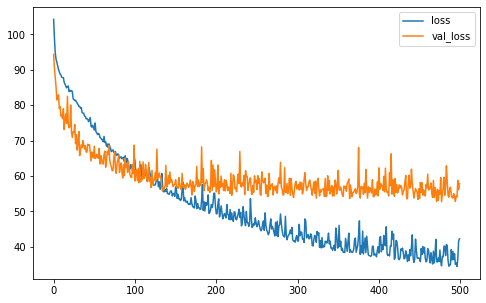

In [87]:
if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

In [88]:
# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features, 
                kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu, kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

In [89]:
# Small Batch size

# On a single data point
history = model.fit(input_train, output_train, validation_data=(input_valid[:10000], output_valid[:10000]), \
                    batch_size=32, epochs=500, verbose=0)

<AxesSubplot:>

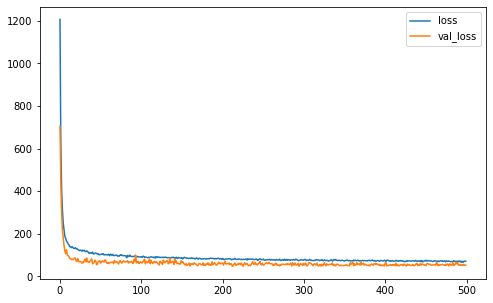

In [90]:
if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

<AxesSubplot:>

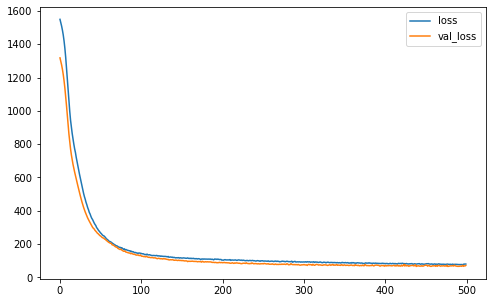

In [91]:
# Without BatchNormalization

# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features, 
                kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu, kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
# model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

# On a single data point
history = model.fit(input_train, output_train, validation_data=(input_valid[:10000], output_valid[:10000]), \
                    batch_size=1024, epochs=500, verbose=0)

if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

<AxesSubplot:>

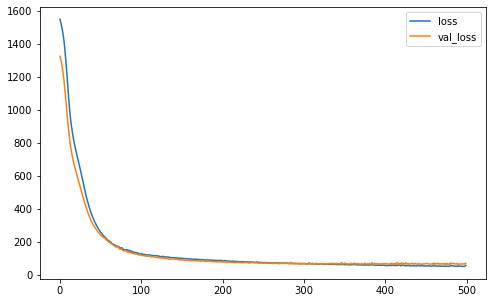

In [92]:
# Without BatchNormalization and Dropout

# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features, 
                kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu, kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
# model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

# On a single data point
history = model.fit(input_train, output_train, validation_data=(input_valid[:10000], output_valid[:10000]), \
                    batch_size=1024, epochs=500, verbose=0)

if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

<AxesSubplot:>

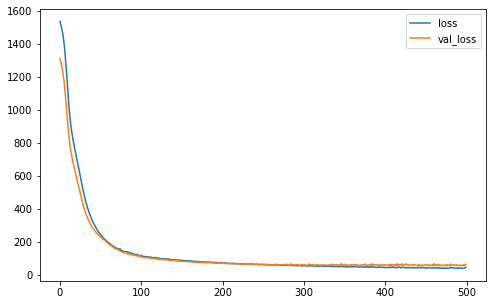

In [93]:
# Without Regularization, BatchNormalization and Dropout

# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
# model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh'))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear'))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

# On a single data point
history = model.fit(input_train, output_train, validation_data=(input_valid[:10000], output_valid[:10000]), \
                    batch_size=1024, epochs=500, verbose=0)

if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

<AxesSubplot:>

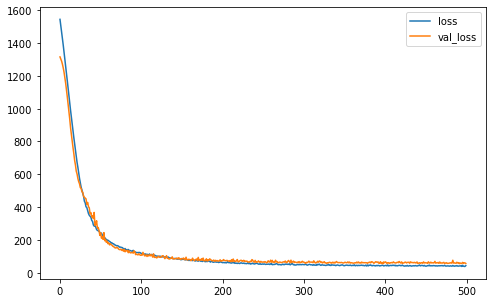

In [94]:
# Without Dropout

# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features, 
                kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu, kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

# On a single data point
history = model.fit(input_train, output_train, validation_data=(input_valid[:10000], output_valid[:10000]), \
                    batch_size=1024, epochs=500, verbose=0)

if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

### With one input sample

Actually it looks nice to have both BatchNormalization and Dropout <br>
The fluctuations of the loss are to be expected. <br>
It would be good to train for 100 epochs!

In [112]:
# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features, 
                kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu, kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

In [113]:
# Large Batch size
history = model.fit(input_train[:1], output_train[:1], validation_data=(input_valid[:1], output_valid[:1]), \
                    batch_size=1024, epochs=500, verbose=0)

<AxesSubplot:>

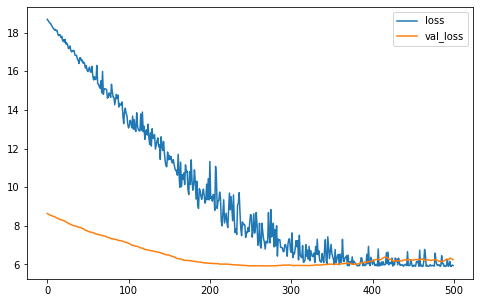

In [114]:
if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

<AxesSubplot:>

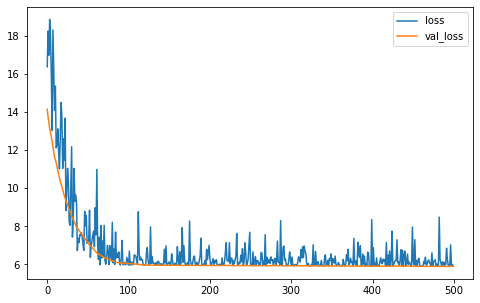

In [105]:
# Without BatchNormalization

# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features, 
                kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu, kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
# model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

# On a single data point
history = model.fit(input_train[:1], output_train[:1], validation_data=(input_valid[:1], output_valid[:1]), \
                    batch_size=1024, epochs=500, verbose=0)

if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

<AxesSubplot:>

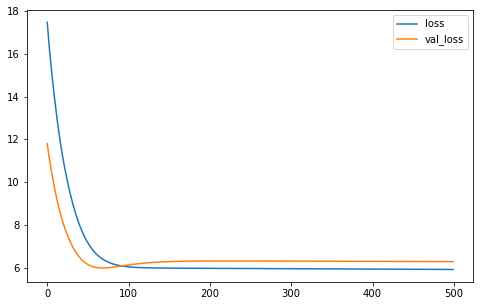

In [104]:
# Without BatchNormalization and Dropout

# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features, 
                kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu, kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
# model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

# On a single data point
history = model.fit(input_train[:1], output_train[:1], validation_data=(input_valid[:1], output_valid[:1]), \
                    batch_size=1024, epochs=500, verbose=0)

if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

<AxesSubplot:>

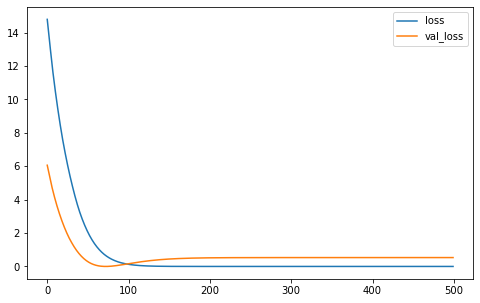

In [110]:
# Without Regularization, BatchNormalization and Dropout

# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
# model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh'))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear'))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

# On a single data point
history = model.fit(input_train[:1], output_train[:1], validation_data=(input_valid[:1], output_valid[:1]), \
                    batch_size=1024, epochs=500, verbose=0)

if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))

<AxesSubplot:>

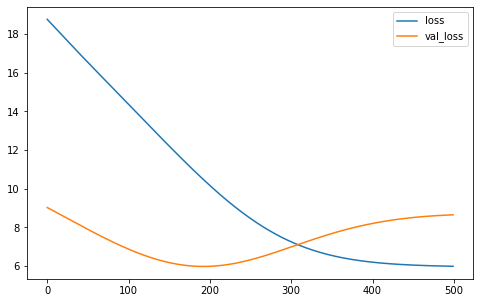

In [111]:
# Without Dropout

# Create the model
model = Sequential()

# First hidden layer
model.add(Dense(units=64, activation='tanh', input_dim=no_of_features, 
                kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

# Second hidden layer
model.add(Dense(units=64, activation=nn.leaky_relu, kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes
model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(units=64, activation='tanh', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))
# model.add(Dropout(0.221)) # We drop 18% of the hidden nodes

# Output layer
model.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=0.004749, l2=0.008732)))

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.000433, epsilon=0.1),
    loss=tf.keras.losses.MeanSquaredError()
)

# On a single data point
history = model.fit(input_train[:1], output_train[:1], validation_data=(input_valid[:1], output_valid[:1]), \
                    batch_size=1024, epochs=500, verbose=0)

if len(history.history['loss']) > len(history.history['val_loss']):
    del history.history['loss'][-1]
pd.DataFrame(history.history).plot(figsize=(8,5))